# <center>Trabajo Práctico Computacional 5:<br>Comunidades</center>

Grupo 9: Facundo Joaquı́n Garcı́a, Agustı́n Brusco, Eitan Sprejer

# Cloning Repo for Data and Imports

In [1]:
import os
directory_path = os.getcwd()
folder_name = os.path.basename(directory_path)
if folder_name == 'content':  # in default colab folder
    if 'CoNet' not in os.listdir():
        !git clone https://github.com/facundojgarcia02/CoNet.git
    os.chdir(r"/content/CoNet/TP5")


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd

from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 100
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

CUSTOM_FORMAT = {"with_labels" : False,
                 "node_size": 10, "node_color": "red", "edgecolors": "black",
                 "linewidths": 0.25, "width": 0.25, "edge_color": "black"}

def custom_draw(graph, ax,
                cmap: str = 'viridis',
                size_degree: bool = False,
                **kwargs):
    k_vals = np.array([k for i, k in graph.degree()])
    norm = plt.Normalize(k_vals.min(), k_vals.max())
    colorscale = plt.cm.ScalarMappable(norm, cmap, )
    if size_degree:
        nx.draw(graph,  with_labels=False,
                node_size=10*np.log(1+k_vals/k_vals.max()) +  4,
                node_color=colorscale.to_rgba(k_vals),
                edgecolors="black", edge_color="black",
                linewidths=0.25, width=0.25,
                ax=ax, **kwargs)
    else:
        nx.draw(graph,  with_labels=False,
                node_size=10,
                node_color=colorscale.to_rgba(k_vals),
                edgecolors="black", edge_color="black",
                linewidths=0.25, width=0.25,
                ax=ax, **kwargs)
    return colorscale

# 2) Red de Coexpresión Génica

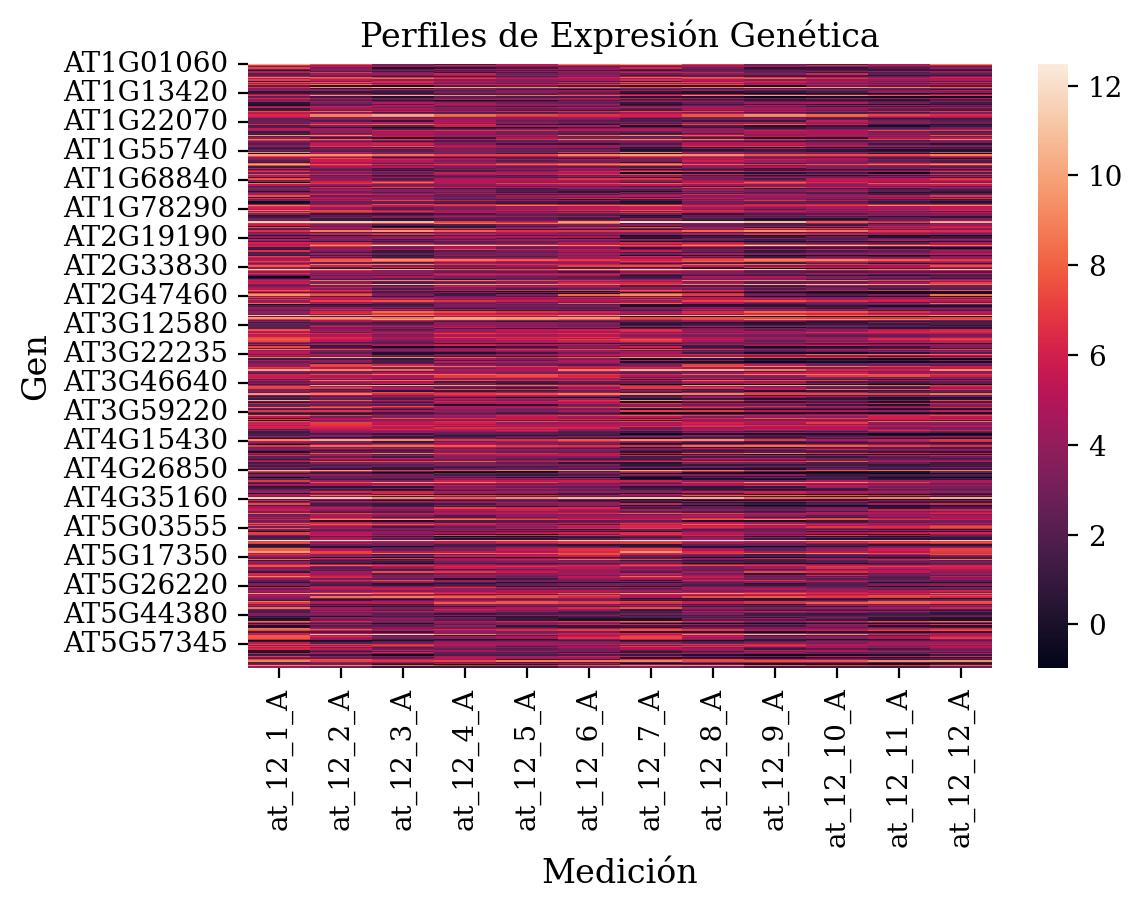

In [38]:
genex_df = pd.read_csv("datasets/geneX.csv", index_col=0)

sns.heatmap(genex_df)
plt.title("Perfiles de Expresión Genética")
plt.ylabel("Gen")
plt.xlabel("Medición")
plt.show()

## a) $s_{ij} = \frac{1 + \mathrm{corr}(A_i,\ A_j)}{2}$

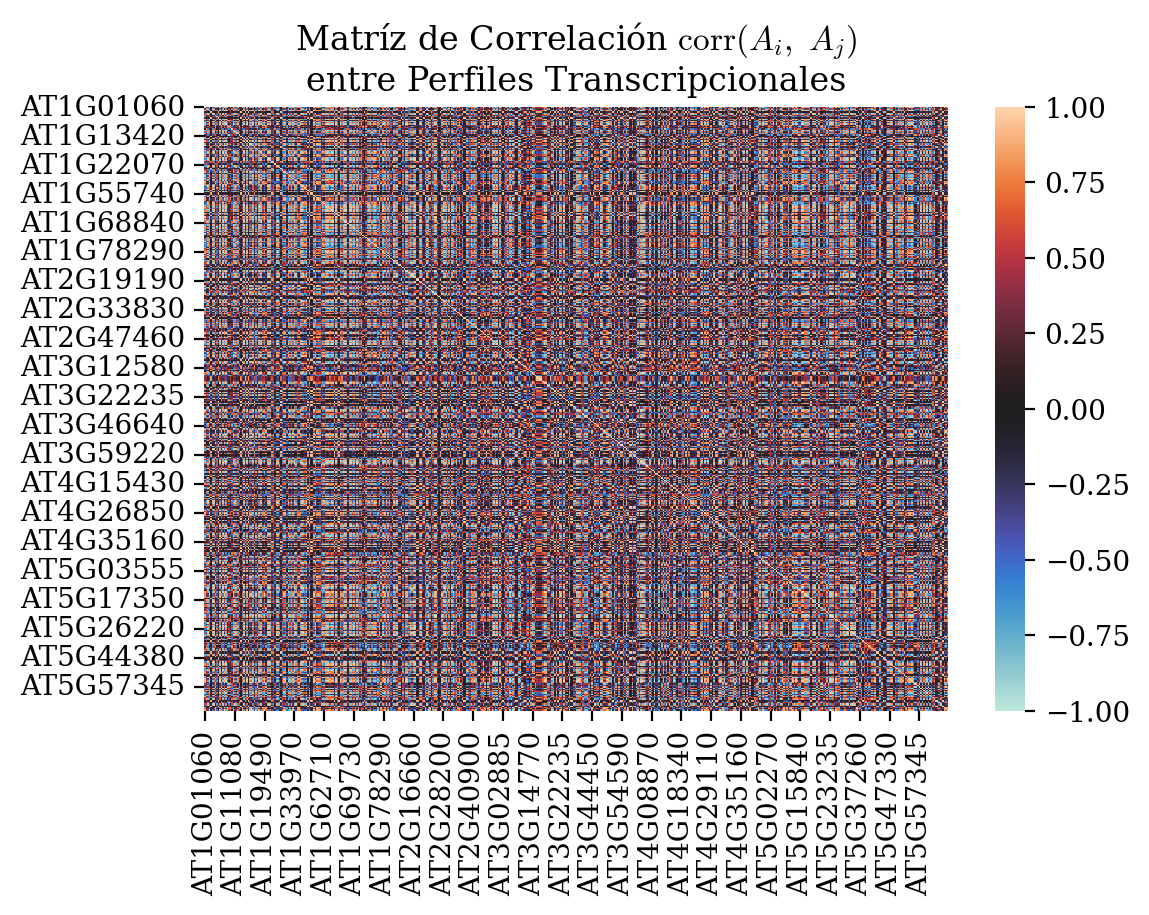

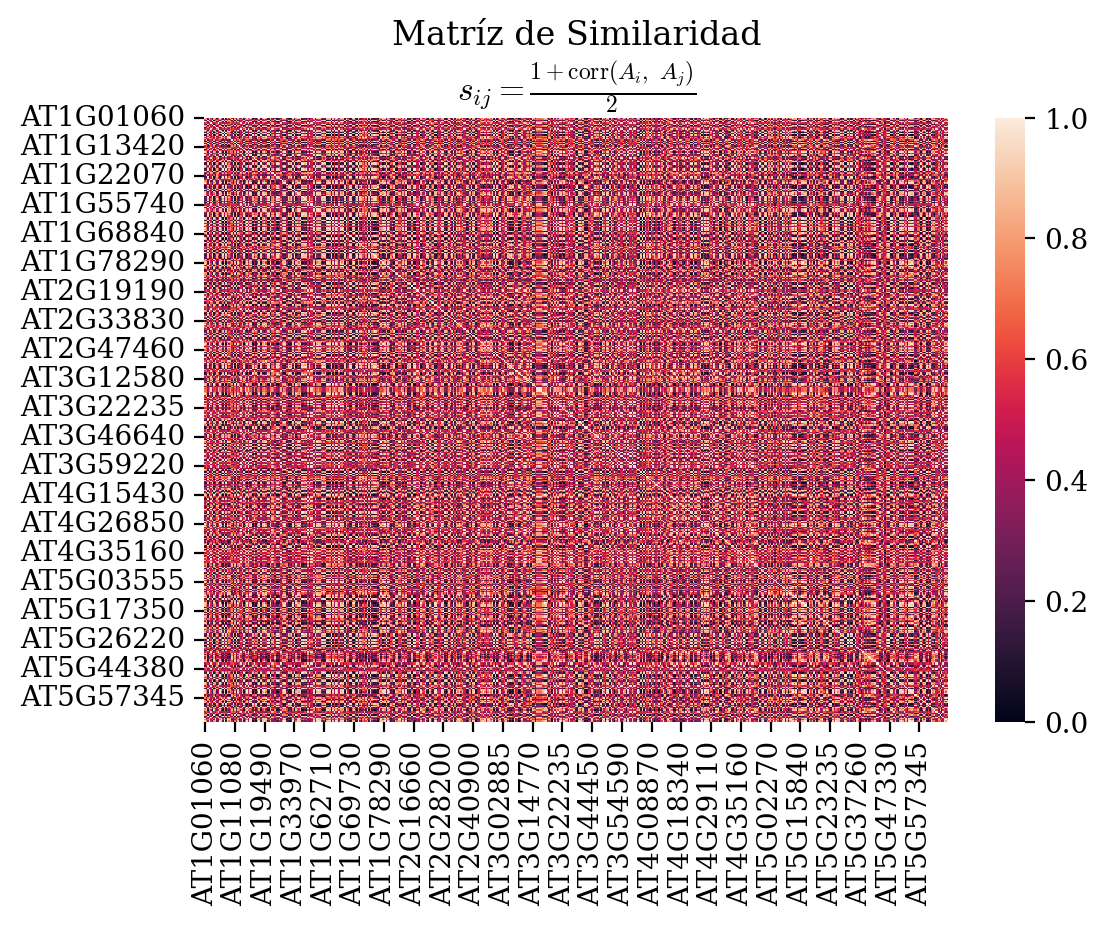

In [42]:
genex_corr = genex_df.T.corr('pearson')
genex_sim = (1 + genex_corr)/2

sns.heatmap(genex_corr, vmin=-1, vmax=1, cmap="icefire")
plt.title("Matríz de Correlación $\\mathrm{corr}(A_i,\\ A_j)$\nentre Perfiles Transcripcionales")
plt.show()

sns.heatmap(genex_sim, vmin=0, vmax=1, cmap="rocket")
plt.title("Matríz de Similaridad\n$s_{ij} = \\frac{1 + \\mathrm{corr}(A_i,\\ A_j)}{2}$")
plt.show()

El elemento $i, j$ de la matriz de correlación se corresponde con la correlación de Pearson entre las vectores-fila $\vec{A_i},\ \vec{A_j}$ de la matriz de expresión génica. Esto es:

\begin{align*}
\mathrm{corr}(A_i,\ A_j) & = \frac{\sum \left(A_{ik} - \langle A_i \rangle \right) \left(A_{jk} - \langle A_j \rangle \right)}{\sqrt{\sum \left(A_{ik} - \langle A_i \rangle \right)^2 \cdot \sum \left(A_{jk} - \langle A_j \rangle \right)^2}} \\
& = \frac{\left(\vec{A_i} - \langle A_i \rangle \right)\cdot \left(\vec{A_j} - \langle A_j \rangle \right)}{||\vec{A_i} - \langle A_i \rangle|| \cdot ||\vec{A_j} - \langle A_j \rangle||} \\
& = \frac{\cos(\theta)||\vec{A_i} - \langle A_i \rangle|| \cdot ||\vec{A_j} - \langle A_j \rangle||}{||\vec{A_i} - \langle A_i \rangle|| \cdot ||\vec{A_j} - \langle A_j \rangle||} = \cos(\theta),
\end{align*}
donde $\theta$ es el ángulo entre los vectores $\vec{A_i}$ y $\vec{A_j}$. Así expresado es fácil notar que $\mathrm{corr}$ toma valores entre $-1$ y $1$ al igual que el coseno.

Luego, para definir una similiridad $s_{ij} \in [0, 1]$ de forma que valga $1$ si los genes $i$ y $j$ presentan respuestas identicas y $0$ en caso de que presenten respuestas completamente opuestas, tiene sentido definir la similaridad del enunciado:

\begin{align*}
s_{ij} & = \frac{1 + \mathrm{corr}(A_i,\ A_j)}{2} \\
& = \frac{1 + \cos(\theta)}{2}.
\end{align*}

Es notable sin embargo que genes cuya respuesta no presente correlación tendrán una similaridad de $0.5$, lo que indica la necesidad de establecer un umbrál alto a la hora de utilizar esta medida de similitud para definir conexiones entre genes.

## b) $a_{ij} = \Theta(s_{ij}-0,\!95)$

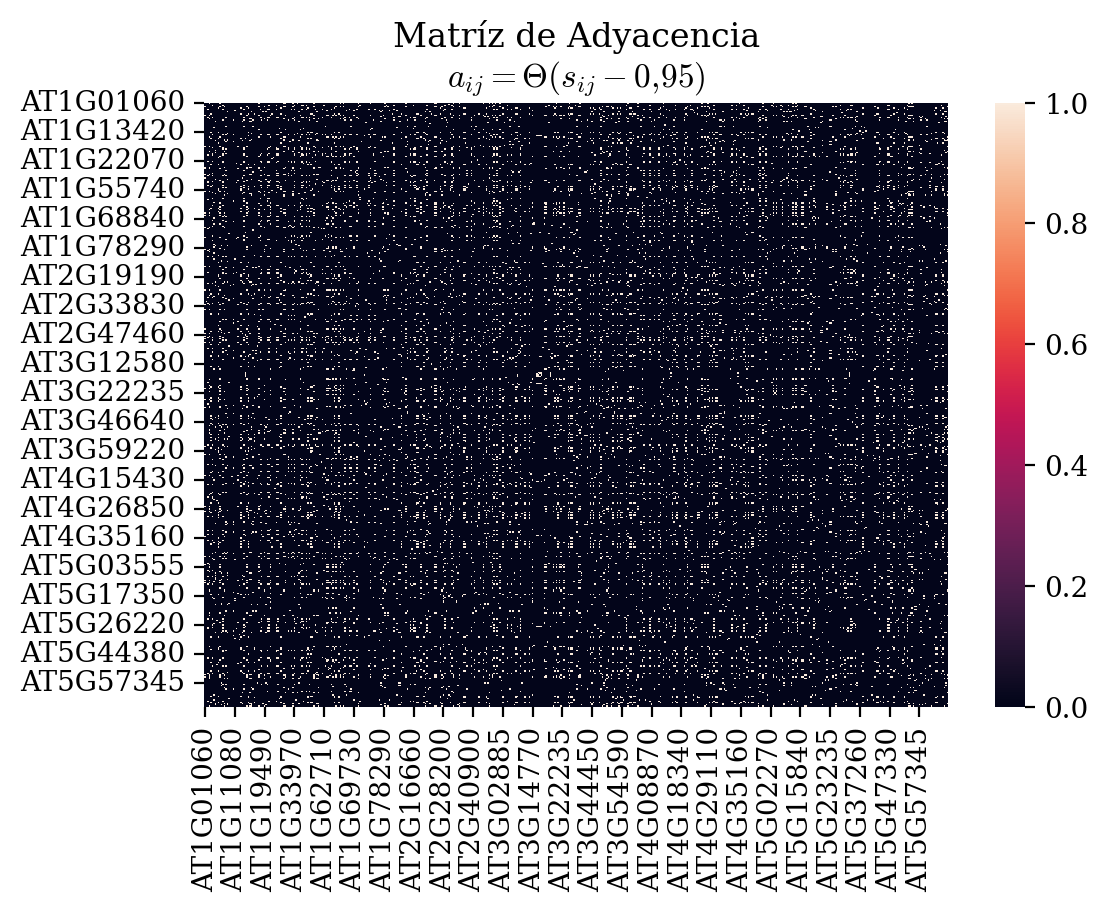

In [43]:
genex_adj = (genex_sim >= 0.95).astype(int) - np.identity(genex_sim.shape[0])


sns.heatmap(genex_adj)
plt.title("Matríz de Adyacencia\n$a_{ij} = \\Theta(s_{ij}-0,\\!95)$")
plt.show()

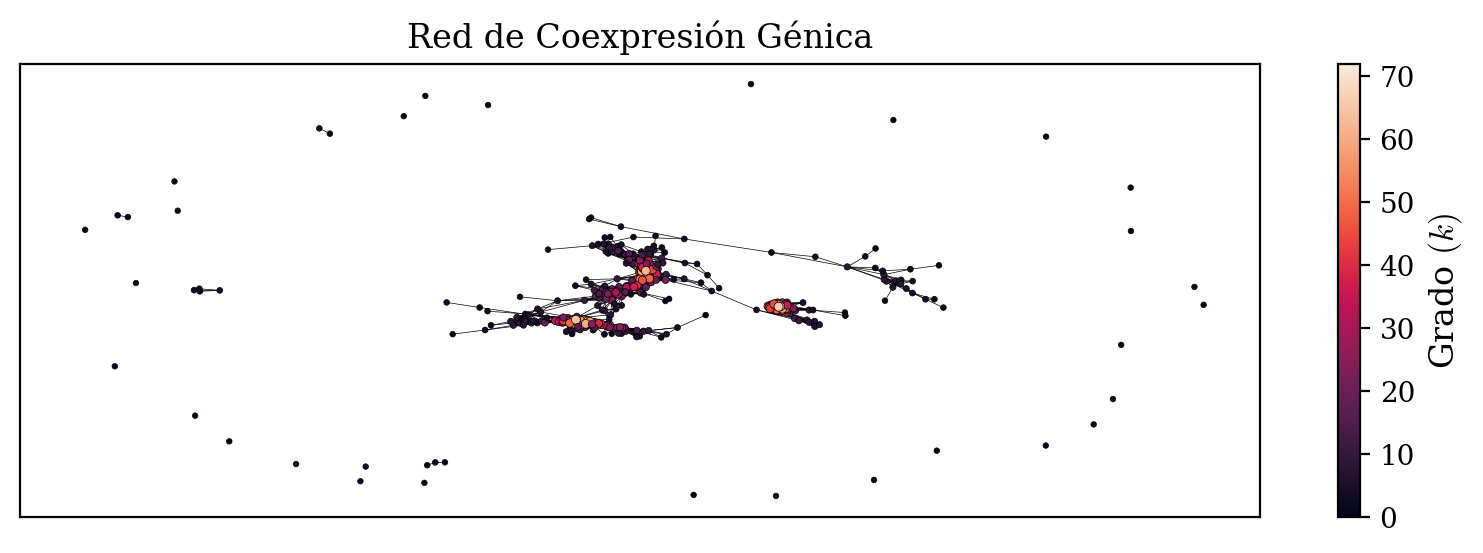

In [69]:
genex_net = nx.from_pandas_adjacency(genex_adj, create_using=nx.Graph, )

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
degree_scale = custom_draw(genex_net, ax,
                           sns.color_palette("rocket", as_cmap=True), size_degree=True)
ax.axis(True)
ax.set_title("Red de Coexpresión Génica")
plt.colorbar(degree_scale, label="Grado $(k)$")
plt.show()

## c) Clusters

In [70]:
# g = sns.clustermap(genex_df, metric="correlation")
# g.figure.set_facecolor('w')
# plt.show()